# **<p style="color:red;">PYNQ FFT Exercise**

![start](../images/prologue.png)

---

# *How to build a hardware FFT accelerator*

![FFT](../images/fft.png)

### Execute all of the following cells, fill in empty cells if instructed.

## 1. Determine what you would like to compute

In this case it has been determined we would like as fast as possible float precision FFT computation up to length 32768 

## 2. Benchmark the Python software

### Exercise:
1. import some useful libraries and modules: numpy as np, random, pynq import Overlay, axitimer
1. load the FFT Overlay that includes an AXI timer IP block and your driver will auto bind to it
    1. '/home/xilinx/jupyter_notebooks/class/Overlays/u96_axi_fft.bit'
1. create test bench complex64 data vectors of length 32768 using random (see example below)
1. use Numpy's built in FFT method and use our AXI timer to measure performance for lengths 64 through 32768 (only the powers of 2 lengths in between)

Import libraries and modules:

In [2]:
import numpy as np
import random
from pynq import Overlay
import axitimer
max_fft_N = 12 # Logic and DMA max for simple mode on ARM32 is 4096 complex 32-bit elements

Load the FFT Overlay and allow axitimer to bind to it:

In [3]:
ol = Overlay('/home/xilinx/jupyter_notebooks/dsp_class/fft.bit')

In [ ]:
ol?

Use Numpy 'complex64' type arrays and establish some test bench data to use when comparing results and performance.

``` python
# Example of creating random value complex value numpy array test data:
size =1024*4  # 4K max length vector
din = np.empty(shape=(size,), dtype='complex64')
din.imag[0:size] = np.random.rand(size,)
din.real[0:size] = np.random.rand(size,)
```

``` python
# Example loop walks through 64 to max length data in powers of 2 using a 100 trial average:
tmr = ol.axi_timer
tmr.start_tmr()
sw_fft_times = []
for i in range(6,max_FFT_N):
    swt = 0
    size = 2 ** i
    din = np.empty(shape=(size,), dtype='complex64')
    din.imag[0:size] = np.random.rand(size,)
    din.real[0:size] = np.random.rand(size,)
    for n in range(0,100):
        start = tmr.read_count()
        dout_sw = np.fft.fftn(din)
        end = tmr.read_count()
        swt += tmr.time_it(start,end)
    sw_fft_times.append([size, 1000*swt/(n+1)])
print('[size, Time in mS]')
print(sw_fft_times)
```

In [4]:
tmr = ol.axi_timer
tmr.start_tmr()
sw_fft_times = []
for i in range(6,max_fft_N+1):
    swt = 0
    size = 2 ** i
    din = np.empty(shape=(size,), dtype='complex64')
    din.imag[0:size] = np.random.rand(size,)
    din.real[0:size] = np.random.rand(size,)
    din[20] = 1.0;
    for n in range(0,100):
        start = tmr.read_count()
        dout_sw = np.fft.fftn(din)
        end = tmr.read_count()
        swt += tmr.time_it(start,end)
    sw_fft_times.append([size, 1000*swt/(n+1)])
print('[size, Time in mS]')
print(sw_fft_times)

[size, Time in mS]
[[64, 0.3447394296552606], [128, 0.4343336895656663], [256, 0.48847497951152496], [512, 0.6284247893715751], [1024, 0.830678799169321], [2048, 1.4075180685924813], [4096, 2.5284997474715003]]


## 3. Build your hardware design

[Block Design Schematics](../Overlays/microsoft_fft.pdf)

![FFT Blocks](../images/axi_fft_blocks.png)

## 4. Create and understand the hardware's configuration and settings

[FFT IP Block Datasheet](../Datasheets/pg109-xfft.pdf)

### FFT Engine setting details:

![FFT Settings1](../images/axi_fft_settings1.png) ![FFT Settings1](../images/axi_fft_settings2.png)

### Summary: FFT is setup for variable length from 64-4096, floating-point, CP is disabled and SCALE_SCH is unused

## 5. Understanding the control bits

[FFT IP Block Datasheet](../Datasheets/pg109-xfft.pdf)

![FFT Config](../images/axi_fft_config.png)

## 6. Create some Python to help with bitpacking the hardware FFT control words

These functions should make life easier, they are already for execution in the cell below:

``` python
# Some convenient helper functions
def bits_to_bytes(bit_str, base=2, byteorder='big') :
    nbytes = int(len(bit_str) * .125 + .9) if base == 2 else int(len(bit_str) * .5 + .9) if base == 16 else 0  
    return int(bit_str, base=base).to_bytes(nbytes, byteorder=byteorder)

def bytes_to_uint32s(byte_s) :
    assert type(byte_s) == bytes, RuntimeError
    return [int.from_bytes(byte_s[i:i+4], byteorder='big') for i in range(0,len(byte_s),4)]

def create_config_tdata(N, fwd_inv=True):
    assert N > 2 and N < 13, RuntimeError
    N = int(N)
    NFFT = N.to_bytes(1, byteorder='big')            # Must be padded to byte
    CP_LEN = ''                                      # padded but unused for this FFT config
    FWD_INV = '0b1' if fwd_inv == True else '0b0'    # No padding
    SCALE_SCH = ''                                   # padded but unused for this FFT config
    return bytes_to_uint32s(bits_to_bytes(FWD_INV) + NFFT) # Final result needs padded to 8 bits worth and converted into 32-bit words for AXI
```

In [5]:
def bits_to_bytes(bit_str, base=2, byteorder='big') :
    nbytes = int(len(bit_str) * .125 + .9) if base == 2 else int(len(bit_str) * .5 + .9) if base == 16 else 0  
    return int(bit_str, base=base).to_bytes(nbytes, byteorder=byteorder)

def bytes_to_uint32s(byte_s) :
    assert type(byte_s) == bytes, RuntimeError
    return [int.from_bytes(byte_s[i:i+4], byteorder='big') for i in range(0,len(byte_s),4)]

def create_config_tdata(N, fwd_inv=True):
    assert N > 2 and N < 13, RuntimeError
    N = int(N)
    NFFT = N.to_bytes(1, byteorder='big')            # Must be padded to byte
    CP_LEN = ''                                      # padded but unused for this FFT config
    FWD_INV = '0b1' if fwd_inv == True else '0b0'    # No padding
    SCALE_SCH = ''                                   # padded but unused for this FFT config
    return bytes_to_uint32s(bits_to_bytes(FWD_INV) + NFFT) # Final result needs padded to 8 bits worth and converted into 32-bit words for AXI

## 7. Configure the hardware FFT

### Exercise:
1. import 'FifoStreamDriver' from the axififo.py module (be sure to bind the driver to the Overlay)
1. create the config words for forward FFT mode and 2^12 = 4096 length (use create_config_tdata), assing the value to 'cfg_data'
1. send the 'cfg_data' to the FFT IP block (use the FIFO stream driver method 'ol.axi_fifo_fft_ctrl.send_tx_pkt')

In [6]:
# The constraints say it should work up to about 150MHz
from pynq import Clocks

In [7]:
from axififo import FifoStreamDriver
ol = Overlay('/home/xilinx/jupyter_notebooks/dsp_class/fft.bit', download=False)
cfg_data = create_config_tdata(max_fft_N, True)
fft_cfg = ol.axi_fifo_fft_ctrl
fft_cfg.send_tx_pkt(cfg_data)

## 8.  Send and receive data to the hardware FFT using DMA

### Exercise:
The FFT has an AXI streaming interface connected to a dual channel DMA IP Block (see diagram above).  The FFT block consumes a length setting worth of 'complex64'
1. import axidma.py to use the module's 'SimpleDmaDriver' class to write and read data to the hardware FFT accelerator
1. reload the Overlay to bind 'SimpleDmaDriver'
1. optionally create alias for the Overlay's 'SimpleDmaDriver'
1. establish proper SimpleDmaDriver.txbuf size and data type by using SimpleDmaDriver.resize_bufs(4096, data_type='complex64')
1. copy the data into the SimpleDmaDriver.txbuf[0:size] member, you could use 'din' from prior cells or create new values directly into txbuf
1. send data with SimpleDmaDriver.send_dma()
1. receive data with SimpleDmaDriver.rcv_dma()
1. the data from the FFT output will be received into SimpleDmaDriver.rxbuf
1. display the values of rxbuf
1. compare the execution timing results with Numpy's FFT (use the same input data for Numpy as you input to the hardware FFT) 

In [8]:
import axidma
ol = Overlay('/home/xilinx/jupyter_notebooks/dsp_class/fft.bit', download=False)
fft = ol.axi_dma
fft.resize_bufs(shape=[size,], dtype='complex64')
fft.txbuf[0:size] = din
fft.send_dma()
fft.rcv_dma()
fft.rxbuf

PynqBuffer([2080.8616   +2076.2485j  ,  -14.424713   +18.065918j,
             -12.008835    -5.257553j, ...,   -3.3780823   +8.32341j ,
              -7.8228607  -13.720352j,   12.099731    -3.609848j],
           dtype=complex64)

In [9]:
np.fft.fftn(din)

array([2080.86161569+2076.24855472j,  -14.42464724  +18.06596014j,
        -12.00877717   -5.25752623j, ...,   -3.37804775   +8.32346054j,
         -7.82282557  -13.7203099j ,   12.09977156   -3.60979947j])

mean squared error: 1.5256948063151306e-10


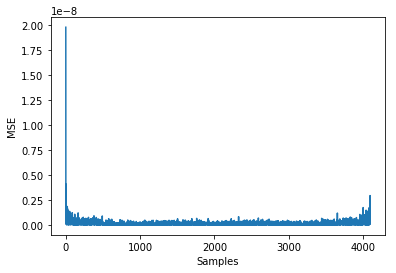

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
hw_fft_data = np.abs(np.array(fft.rxbuf))
sw_fft_data = np.abs(np.array(np.fft.fftn(din)))
err_squared = (hw_fft_data-sw_fft_data)**2
f, ax = plt.subplots()
ax.plot(err_squared)
ax.set_xlabel('Samples')
ax.set_ylabel('MSE');
print('mean squared error: ' + str(err_squared.mean()))

### Do the results match exactly or are they just close?

## 9. Benchmarking: copy DMA driver FFT vs. Numpy FFT

The custom DMA driver in axidma.py has 2 methods to read and write data with DMA. The 1st method 'send_cpy()' and 'rcv_cpy()' is convenient, just pass in a list of data and the method handles all the details including the allocate type buffers.  Along the way it makes a copy of the data however.  The 2nd method 'send_dma()' and 'rcv_dma()' requires pre-sizing built in 'rxbuf' and 'txbuf' buffers and loading the data into those buffers. This eliminates a copy each time and type allocate buffer allocation and free.

### Exercise:
1. use the example from the beginning but enhance it to use both the hardware and software versions of the FFT
1. use the SimpleDmaDriver.send_cpy() and .rcv_cpy() methods
1. enhance it to use the AXI hardware timer for measurement
    1. use the timer to measure execution times of both the HW and SW FFT
1. collect the metrics for 100 runs of both SW and HW and for each length from: 64 - 4096 in steps of powers of 2
1. compare the execution times between the convenient copy DMA methods here vs the Numpy FFT

In [11]:
sw_fft_times = []
hw_fft_times = []
tmr.start_tmr()
for i in range(6,max_fft_N+1):
    hwt = swt = 0
    size = 2 ** i
    din = np.empty(shape=(size,), dtype=np.complex64)
    din.imag[0:size] = np.random.rand(size,)
    din.real[0:size] = np.random.rand(size,)
    fft_cfg.send_tx_pkt(create_config_tdata(i, 1))
    for n in range(0,100):
        start = tmr.read_count()
        dout_sw = np.fft.fftn(din)
        end = tmr.read_count()
        swt += tmr.time_it(start,end)
        start = tmr.read_count()
        fft.send_cpy(din)
        dout = fft.rcv_cpy(size, np.complex64)
        end = tmr.read_count()
        hwt += tmr.time_it(start,end)
    sw_fft_times.append([size, 1000*swt/(n+1)])
    hw_fft_times.append([size, 1000*hwt/(n+1)])
print('Times are in mS')
print(sw_fft_times)
print(hw_fft_times)
print('Acceleration factor:')
a = []
for i in range(0,len(hw_fft_times)):
    a.append([sw_fft_times[i][0], sw_fft_times[i][1]/hw_fft_times[i][1]])
print(a)

Times are in mS
[[64, 0.5480366494519633], [128, 0.5669544294330457], [256, 0.610677059389323], [512, 0.7226246992773754], [1024, 0.9526475690473524], [2048, 1.504917398495082], [4096, 2.608132727391867]]
[[64, 2.8564588471435424], [128, 2.900765977099234], [256, 2.90669028709331], [512, 2.9795929770204066], [1024, 3.1767541368232464], [2048, 3.5481924764518085], [4096, 4.263107515736891]]
Acceleration factor:
[[64, 0.1918587589665434], [128, 0.1954499032010849], [256, 0.21009361131488147], [512, 0.2425246350258216], [1024, 0.2998807990850686], [2048, 0.42413634786802745], [4096, 0.6117914497263256]]


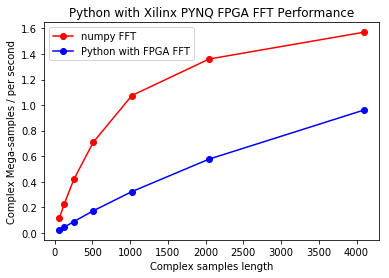

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
f, ax = plt.subplots()
ax.plot([i[0] for i in sw_fft_times], [i[0]/(i[1] * .001) / 1e6 for i in sw_fft_times], 'r-o', label='numpy FFT')
ax.plot([i[0] for i in hw_fft_times], [i[0]/(i[1] * .001) / 1e6 for i in hw_fft_times], 'b-o', label='Python with FPGA FFT')
ax.set_xlabel('Complex samples length')
ax.set_ylabel('Complex Mega-samples / per second')
ax.legend()
ax.set_title('Python with Xilinx PYNQ FPGA FFT Performance');

## 10. Benchmark the system: pre-buf DMA FFT vs Numpy FFT

### Exercise:
1. use the example from the beginning but enhance it to use both the hardware and software versions of the FFT
1. this time use the SimpleDmaDriver.send_dma() and .rcv_dma() methods to transfer the data, resize the buffers properly before using those methods
1. enhance the program to use the AXI hardware timer for measurements
    1. use the timer to measure execution times of both the HW and Numpy FFT
1. collect the metrics for 100 runs of both Numpy and HW FFT and for each length from: 64 - 4096 in steps of powers of 2
1. compare HW vs Numpy FFT execution times
1. for the 4096 length hardware FFT, compare the fast DMA method vs. the Numpy performance in units of Complex Mega Samples per Second (samples/time)

In [13]:
sw_fft_times = []
hw_fft_times = []
tmr.start_tmr()
for i in range(6,max_fft_N+1):
    hwt = swt = 0
    size = 2 ** i
    fft.resize_bufs(size, dtype=np.complex64)
    din = np.empty(shape=(size,), dtype=np.complex64)
    fft.txbuf.imag[0:size] = np.random.rand(size,)
    fft.txbuf.real[0:size] = np.random.rand(size,)
    fft_cfg.send_tx_pkt(create_config_tdata(i, 1))
    for n in range(0,100):
        start = tmr.read_count()
        dout_sw = np.fft.fftn(fft.txbuf)
        end = tmr.read_count()
        swt += tmr.time_it(start,end)
        start = tmr.read_count()
        fft.send_dma()
        fft.rcv_dma()
        end = tmr.read_count()
        hwt += tmr.time_it(start,end)
    sw_fft_times.append([size, 1000*swt/(n+1)])
    hw_fft_times.append([size, 1000*hwt/(n+1)])
print('Times are in mS')
print(sw_fft_times)
print(hw_fft_times)
print('Acceleration factor:')
a = []
for i in range(0,len(hw_fft_times)):
    a.append([sw_fft_times[i][0], sw_fft_times[i][1]/hw_fft_times[i][1]])
print(a)
fft.txbuf.close()
fft.rxbuf.close()

Times are in mS
[[64, 0.521088049478912], [128, 0.5572716794427286], [256, 0.6310357193689643], [512, 0.8059211991940791], [1024, 1.132341978867658], [2048, 1.89472030810528], [4096, 3.444231136555769]]
[[64, 0.708256919291743], [128, 0.7153099092846898], [256, 0.7176161992823837], [512, 0.7231774892768226], [1024, 0.7182501192817498], [2048, 0.7209211092790792], [4096, 0.7472656792527339]]
Acceleration factor:
[[64, 0.7357330868013264], [128, 0.7790632734278775], [256, 0.8793498808973377], [512, 1.114416877107168], [1024, 1.5765287724560355], [2048, 2.6281936868237907], [4096, 4.609111902476242]]


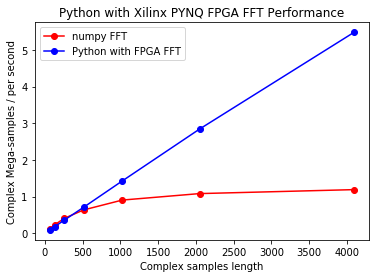

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
f, ax = plt.subplots()
ax.plot([i[0] for i in sw_fft_times], [i[0]/(i[1] * .001) / 1e6 for i in sw_fft_times], 'r-o', label='numpy FFT')
ax.plot([i[0] for i in hw_fft_times], [i[0]/(i[1] * .001) / 1e6 for i in hw_fft_times], 'b-o', label='Python with FPGA FFT')
ax.set_xlabel('Complex samples length')
ax.set_ylabel('Complex Mega-samples / per second')
ax.legend()
ax.set_title('Python with Xilinx PYNQ FPGA FFT Performance');

In [15]:
print('CMS/sec: ' + str(2**max_fft_N/(hw_fft_times[i][1] * .001) / 1e6))

CMS/sec: 5.481316904713196


In [16]:
print('CMS/sec: ' + str(2**max_fft_N/(sw_fft_times[i][1] * .001) / 1e6))

CMS/sec: 1.189234937378796


## 11. Plot an audio spectrogram of FFT data

Finally here is a simple but complete example showing how various Python libraries can be combined together with PYNQ and a PL hardware accelerator:

In [ ]:
%matplotlib inline
import numpy as np
from scipy.io import wavfile
import matplotlib.pyplot as plt
from pynq import Overlay
import axidma
import axififo
from math import log2
import warnings
warnings.filterwarnings('ignore')

def bits_to_bytes(bit_str, base=2, byteorder='big') :
    nbytes = int(len(bit_str) * .125 + .9) if base == 2 else int(len(bit_str) * .5 + .9) if base == 16 else 0  
    return int(bit_str, base=base).to_bytes(nbytes, byteorder=byteorder)

def bytes_to_uint32s(byte_s) :
    assert type(byte_s) == bytes, RuntimeError
    return [int.from_bytes(byte_s[i:i+4], byteorder='big') for i in range(0,len(byte_s),4)]

def create_config_tdata(N, fwd_inv=True):
    assert N > 2 and N < 13, RuntimeError
    N = int(N)
    NFFT = N.to_bytes(1, byteorder='big')            # Must be padded to byte
    CP_LEN = ''                                      # padded but unused for this FFT config
    FWD_INV = '0b1' if fwd_inv == True else '0b0'    # No padding
    SCALE_SCH = ''                                   # padded but unused for this FFT config
    return bytes_to_uint32s(bits_to_bytes(FWD_INV) + NFFT) # Final result needs padded to 8 bits worth and converted into 32-bit words for AXI

ol = Overlay('/home/xilinx/jupyter_notebooks/class/Overlays/microzed_fft.bit')
fft = ol.axi_dma
fft_cfg = ol.axi_fifo_fft_ctrl

In [ ]:
rate, audio = wavfile.read('baltimore_oriole.wav')

In [ ]:
N = audio.shape[0]
L = N / rate

print(f'Audio length: {L:.2f} seconds')

# Config the FPGA fft
M = 4096
cfg_data = create_config_tdata(log2(M), 1)
fft_cfg.send_tx_pkt(cfg_data)

# Extract strided windows
stride_size = 100
window_size = M
truncate_size = (len(audio) - window_size) % stride_size
audio = audio[0:len(audio) - truncate_size]
nshape = (window_size, (len(audio) - window_size) // stride_size + 1)
nstrides = (audio.strides[0], audio.strides[0] * stride_size)
slices = np.lib.stride_tricks.as_strided(audio, 
                                         shape = nshape, strides = nstrides)
print(f'Number of {M} length FFTs to perform: {slices.shape[1]}')
win = np.hanning(M + 1)[:-1]
win = np.expand_dims(win, axis=-1)
slices = (slices * win).T
fft.resize_bufs(shape=[M,], dtype=np.complex64)

spectrum = np.empty(shape=[M // 2 + 1 - 3, slices.shape[1]], dtype=np.complex64)

print('Data copies and FFT calculations begin...')
for i in range(slices.shape[1]):
    #  Comment these lines out and test the Numpy FFT if you like
    fft.txbuf[0:M] = slices[i,:]
    fft.send_dma()  # These 2 lines replace np.fft
    fft.rcv_dma()   # These 2 lines replace np.fft
    spectrum[:,i] = fft.rxbuf[:M // 2 + 1:-1]
    
    # Uncomment to run the Numpy FFT
    #spectrum[:,i] = np.fft.fftn(slices[i,:])[:M // 2 + 1:-1]
print('FFT calculations complete.')

print('Preparing plots and plotting...')
# Create plots of time and spectrum
N = audio.shape[0]  # Recaluate N, Audio may be trimmed
f, ax = plt.subplots()
ax.plot(np.arange(N) / rate, audio)
ax.set_xlabel('Time [s]')
ax.set_ylabel('Amplitude');
    
spectrum = np.abs(spectrum)
f, ax = plt.subplots(figsize=(4.8, 2.4))

S = np.abs(spectrum)
S = 20 * np.log10(S / np.max(S))

ax.imshow(S, origin='lower', cmap='viridis',
          extent=(0, L, 0, rate / 2 / 1000))
ax.axis('tight')
ax.set_ylabel('Frequency [kHz]')
ax.set_xlabel('Time [s]');

In [ ]:
from IPython.display import Audio
Audio('baltimore_oriole.wav')

In [ ]:
from IPython.display import Image
Image(filename='baltimore_oriole.jpg') 

![end](../images/epilogue.png)